In [1]:
import scipy
import numpy as np
import h5py
import glob
import pickle
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, SpatialDropout2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow import keras

In [ ]:
# GPU check for tensorflow/keras
print(tf.config.list_physical_devices('GPU'))
print( tf.test.is_built_with_cuda())

In [ ]:
# Allow GPU growth for CUDA
# See if the GPU produces weird glitches first
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.99)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [ ]:
# Function to read the image files
def load_files(path, target_size, scale_factor, img_type = 'image'):
    '''
    Function:
    Reads images of 'tif' from from a given path file.
    
    Parameters:
    path: type- string. tif image path.
    target_size: type - int. resizing dimension.
    scale_factor: type - float. scaling value.
    img_type: type - string. 'mask' to indicate loading mask files.
    '''
    image_list = []
    filenames = glob.glob(path)
    filenames.sort()
    for filename in tqdm(filenames):
        if img_type == 'mask':
            im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, dsize=(target_size, target_size), interpolation=cv2.INTER_CUBIC)
            _, im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY_INV)
        else:
            im = cv2.imread(filename)
            im = cv2.resize(im, dsize=(target_size, target_size), interpolation=cv2.INTER_CUBIC)
        im=np.asarray(im) / scale_factor
        image_list.append(im)
    return np.asarray(image_list)

In [ ]:
resize = 1024 # Resizing dimension
scale = 255.0 # Scaling value for RGB images (range 0 - 255)

image_list = load_files(r'aerialimagelabeling/AerialImageDataset/train/images/*.tif', resize, scale)
mask_list = load_files(r'aerialimagelabeling/AerialImageDataset/train/gt/*.tif', resize, scale, 'mask')
mask_list = np.reshape(mask_list, (np.shape(mask_list) + (1, )))

print(np.shape(image_list))
print(np.shape(mask_list))

In [ ]:
def display_images(im_list, msk_list, img_to_disp = 8):
    fig = plt.figure(figsize = (20,15))
    for i, (im, msk) in enumerate(zip(im_list[:img_to_disp], msk_list[:img_to_disp])):
        ax = fig.add_subplot(4, 8, i*2+1)
        ax.imshow(im)
        ax = fig.add_subplot(4, 8, i*2+2)
        ax.imshow(msk)
        
        plt.tight_layout()

In [ ]:
display_images(image_list, mask_list)

In [ ]:
# Fuction to save the resized images in compressed format.
# Can be used to load the saved images quickly during network trial.
def save_images(h5_name, train, mask):
    with h5py.File(h5_name, 'w') as hf:
        Xset = hf.create_dataset(name='imgs', data=train, compression="gzip", compression_opts=9)
        yset = hf.create_dataset(name='masks', data=mask, compression="gzip", compression_opts=9)
        
    hf.close()
    
save_images('image_files_1024.h5', image_list, mask_list)

In [ ]:
###################################################
# Run this only if you have the h5 files
# and don't want to process all the images again.
# Otherwise run the two cells above.
###################################################

with h5py.File('train.h5', 'r') as hf:
    image_list = np.array(hf['imgs'])
    mask_list = np.array(hf['masks'])


# with h5py.File('test.h5', 'r') as hf:
#     test_imgs = np.array(hf['imgs'])
#     test_masks = np.array(hf['masks'])

In [ ]:
seed = 42

X_train, X_test, y_train, y_test = train_test_split(image_list, mask_list, test_size=0.3, random_state=seed)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
def random_crop(img_x, img_y, random_crop_size):
    height, width = img_x.shape[0], img_x.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img_x[y:(y+dy), x:(x+dx), :], img_y[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops_x = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        batch_crops_y = np.zeros((batch_x.shape[0], crop_length, crop_length, 1))
        for i in range(batch_x.shape[0]):
            batch_crops_x[i], batch_crops_y[i] = random_crop(batch_x[i], batch_y[i], (crop_length, crop_length))
        yield (batch_crops_x, np.where(batch_crops_y > 0.5, 1, 0))

In [42]:
train_datagen = ImageDataGenerator(zoom_range=0.1, horizontal_flip=True)
train_image_generator = train_datagen.flow(X_train, batch_size = 16, seed=4)
train_mask_generator = train_datagen.flow(y_train, batch_size = 16, seed=4)

In [43]:
train_generator = crop_generator(zip(train_image_generator, train_mask_generator), 128)

In [44]:
val_datagen = ImageDataGenerator(zoom_range=0.1)
test_image_generator = val_datagen.flow(X_test, batch_size = 16, seed=4)
test_mask_generator = val_datagen.flow(y_test, batch_size = 16, seed=4)
test_generator = crop_generator(zip(test_image_generator, test_mask_generator), 128)

In [ ]:
sample = next(train_generator)
fig = plt.figure(figsize=[20, 25])
for i,(img, msk) in enumerate(zip(sample[0][:32], sample[1][:32])):
    ax = fig.add_subplot(8, 8, i*2 + 1)
    ax.imshow(img)
    ax = fig.add_subplot(8, 8, i*2 + 2)
    ax.imshow(msk, cmap = 'gray')

In [45]:
def show_prediction(model, test_data, test_gt):
    pred = model.predict(test_data)
    pred_ = np.where(pred > 0.5, 1, 0)
    fig = plt.figure(figsize=[20, 25])
    for i, (img, msk) in enumerate(zip(test_data[0:6], test_gt[0:6])):
        ax = fig.add_subplot(3, 6, i*3 + 1)
        ax.imshow(img)
        ax.set_title("Image")
        ax = fig.add_subplot(3, 6, i*3 + 2)
        ax.set_title("Original Mask")
        ax.imshow(msk)
        ax = fig.add_subplot(3, 6, i*3 + 3)
        ax.imshow(pred_[i])
        ax.set_title("Predicted")
        plt.tight_layout()

In [2]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3

input_img = Input(shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS))

# Contraction Part
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(input_img) # Output 128 x 128
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(conv1) # Output 128 x 128
conv1 = Dropout(0.1)(conv1)
pool1 = MaxPooling2D((2,2))(conv1) # Downsample 64 x 64

conv2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(pool1) # Output 64 x 64
conv2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv2) # Output 64 x 64
conv2 = Dropout(0.1)(conv2)
pool2 = MaxPooling2D((2, 2))(conv2) # Downsample 32 x 32

conv3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool2) # Output 32 x 32
conv3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv3) # Output 32 x 32
conv3 = Dropout(0.1)(conv3)
pool3 = MaxPooling2D((2, 2))(conv3) # Downsample 16 x 16

conv4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool3) # Output 16 x 16
conv4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv4) # Output 16 x 16
conv4 = Dropout(0.1)(conv4)
pool4 = MaxPooling2D((2, 2))(conv4) # Downsample 8 x 8

conv5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool4) # Output 8 x 8
conv5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv5) # Output 8 x 8

# Expansion Part
up1 = UpSampling2D((2, 2))(conv5) # Upsample 16 x 16

merge1 = concatenate([conv4, up1], axis = 3)
conv6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(merge1) # Output 16 x 16
conv6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv6) # Output 16 x 16
conv6 = Dropout(0.1)(conv6)
up2 = UpSampling2D((2, 2))(conv6) # Upsample 32 x 32

merge2 = concatenate([conv3, up2], axis = 3)
conv7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(merge2) # Output 32 x 32
conv7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv7) # Output 32 x 32
conv7 = Dropout(0.1)(conv7)
up3 = UpSampling2D((2, 2))(conv7) # Upsample 64 x 64

merge3 = concatenate([conv2, up3], axis = 3)
conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(merge3) # Output 64 x 64
conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8) # Output 64 x 64
conv8 = Dropout(0.1)(conv8)
up3 = UpSampling2D((2, 2))(conv8) # Upsample 128 x 128

merge3 = concatenate([conv1, up3], axis = 3)
conv8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(merge3) # Output 128 x 128
conv8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv8) # Output 128 x 128
conv8 = Dropout(0.1)(conv8)

decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv8)

model = Model(input_img, decoded, name='model')

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    decay_rate=0.9)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

# sparse_categorical_crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

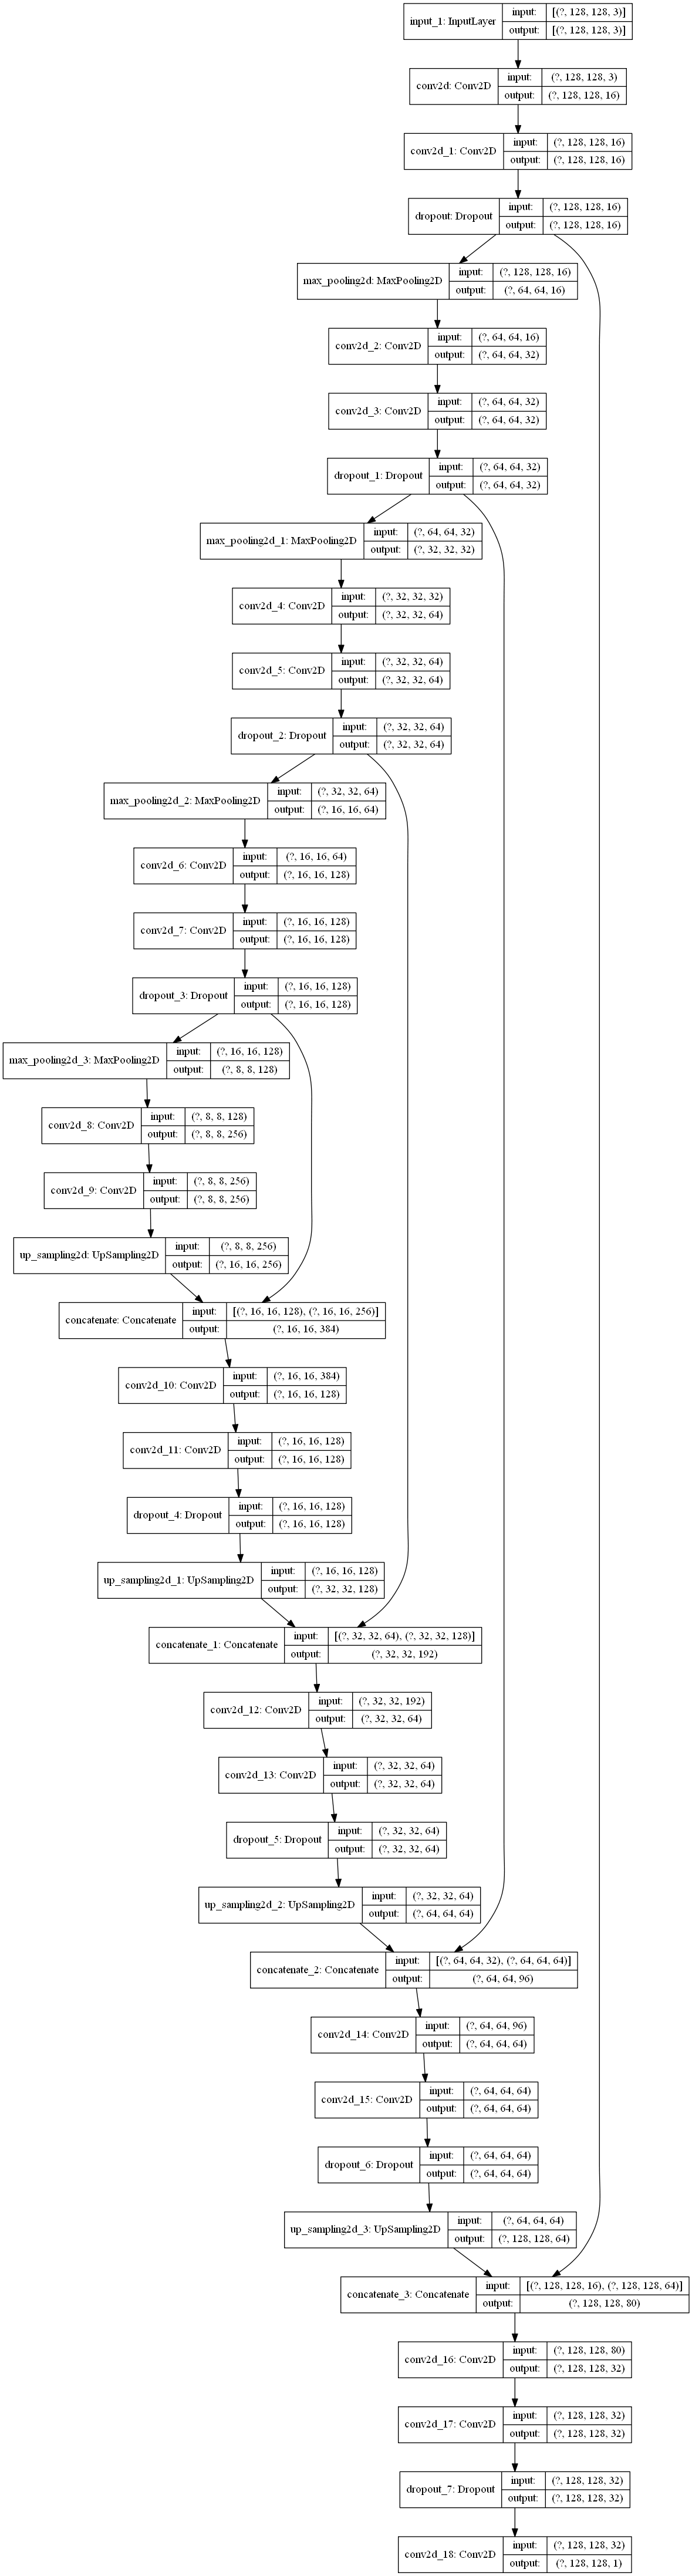

In [4]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [50]:
callbacks = [ModelCheckpoint('segmenter_final.h5', verbose = 1, save_best_only = True),
            EarlyStopping(patience = 3, monitor = 'val_loss')]
history = model.fit(train_generator, steps_per_epoch = 10, epochs=15,
              validation_data=test_generator, validation_steps = 10, callbacks = callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/15
 9/10 [==========================>...] - ETA: 8s - loss: 1343.5694 - accuracy: 0.8308 
Epoch 00001: val_loss improved from inf to 0.48685, saving model to segmenter_final.h5
10/10 [==============================] - 105s 11s/step - loss: 1210.6545 - accuracy: 0.8351 - val_loss: 0.4869 - val_accuracy: 0.8393
Epoch 2/15
 9/10 [==========================>...] - ETA: 0s - loss: 0.6126 - accuracy: 0.8142
Epoch 00002: val_loss did not improve from 0.48685
10/10 [==============================] - 39s 4s/step - loss: 0.6116 - accuracy: 0.8201 - val_loss: 0.5964 - val_accuracy: 0.8437
Epoch 3/15
 9/10 [==========================>...] - ETA: 0s - loss: 0.5081 - accuracy: 0.8340
Epoch 00003: val_loss improved from 0.48685 to 0.45194, saving model to segmenter_final.h5
10/10 [==============================] - 40s 4s/step - loss: 0.5131 - accuracy: 0.8289 - val_loss: 0.4519 - val_accuracy: 0.8425
E

In [ ]:
save_pickle("/final_model/history.pkl", history.history)

In [ ]:
segmenter_3.save("model.h5")

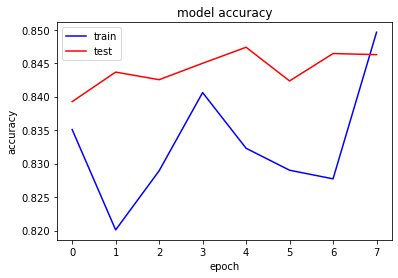

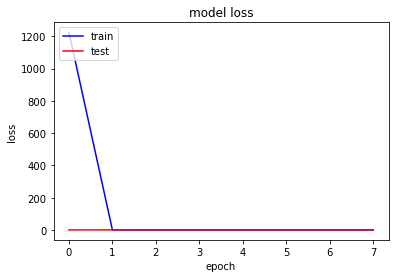

In [51]:
plt.plot(history.history['accuracy'], c='b')
plt.plot(history.history['val_accuracy'], c='r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], c='b')
plt.plot(history.history['val_loss'], c='r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

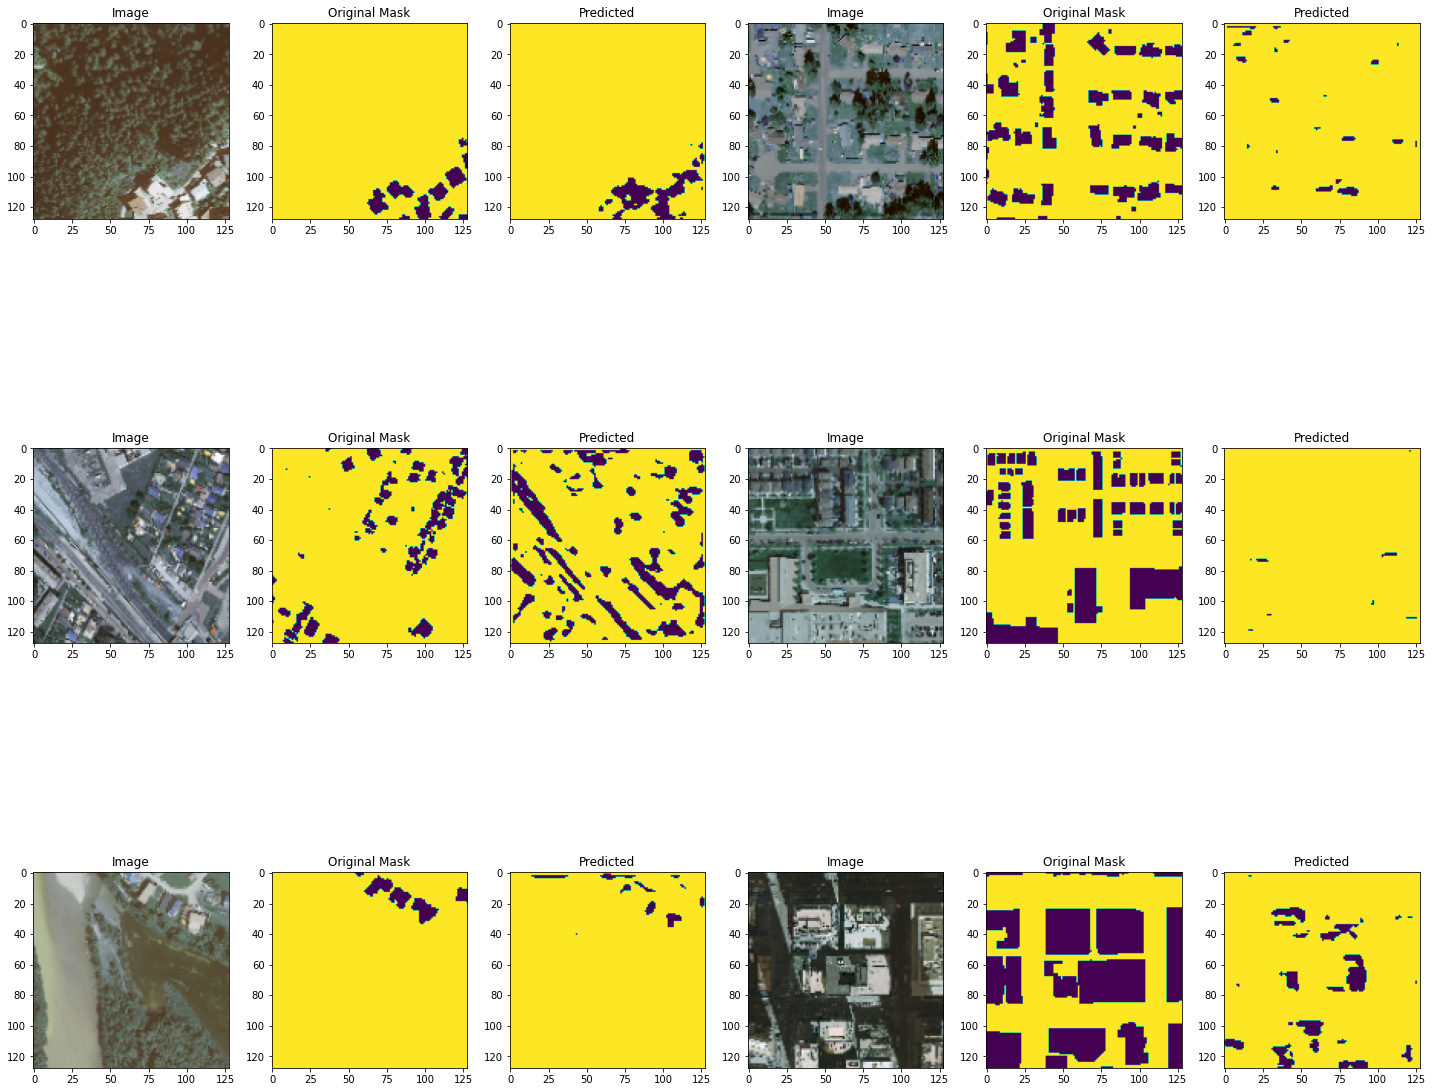

In [41]:
model = keras.models.load_model('segmenter_final.h5')

test_data, test_gt = next(test_generator)

show_prediction(model, test_data, test_gt)